## Reference
- MS Swin Transformer : https://github.com/SwinTransformer/Swin-Transformer-Object-Detection
- Pytorch Image Model : https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/swin_transformer.py

## About model
선정 모델: Swin Transformer 중 Swin-T

선정 데이터셋: ImageNet


 Mask R-CNN + Swin-T 백본 모델에 Pruning 계획

mAP 성능지표 및 detection 속도, 파라미터 수를 기반으로 진행

### Issue
- Mask R-CNN 적용을 위해 mmcv 활용하고자 함 => Colab 내 mmcv-full pip 진행이 X (1시간 이상 걸림)
  => Image Classification 으로 임시 테스트 진행하고자함
- ImageNet 모델의 용량문제, Colab의 용량이 감당 X
  => ImageNet Tiny 데이터셋으로 진행하고자 함

- ImageNet Tiny로 진행한 검증 및 경량화 후 성능이 매우 낮게 측정됨



전체적인 실행환경은 Colab을 이용하였습니다.

시스템 RAM
51.0 GB

GPU RAM (T4 GPU)
15.0 GB

디스크
235.7 GB

python 12.6.2

torch 2.5.1+cu124



#### Pruning 전후 모든 결과의 정확도가 1% 미만으로 측정됩니다.. 데이터셋의 문제인지, 제가 잘못 하고있는건지 잘 모르겠습니다..


In [4]:
!pip list

Package                            Version
---------------------------------- ------------------
absl-py                            1.4.0
accelerate                         1.3.0
aiohappyeyeballs                   2.4.6
aiohttp                            3.11.13
aiosignal                          1.3.2
alabaster                          1.0.0
albucore                           0.0.23
albumentations                     2.0.5
ale-py                             0.10.2
altair                             5.5.0
annotated-types                    0.7.0
anyio                              3.7.1
argon2-cffi                        23.1.0
argon2-cffi-bindings               21.2.0
array_record                       0.6.0
arviz                              0.20.0
astropy                            7.0.1
astropy-iers-data                  0.2025.3.3.0.34.45
astunparse                         1.6.3
atpublic                           4.1.0
attrs                              25.1.0
audioread            

Using device: cuda
Loading pretrained swin_tiny_patch4_window7_224...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Extracting dataset...
Dataset extracted to /content/tiny-imagenet-200
Organizing validation data...
Loaded 100000 training images and 20000 validation images

Evaluating original model...
Original model accuracy: 0.29%

Pruning with ratio 0.20...
Generating pruning masks...
patch_embed.proj.weight: 923/4608 parameters pruned (20.03%)
layers.0.blocks.0.attn.qkv.weight: 5531/27648 parameters pruned (20.01%)
layers.0.blocks.0.attn.proj.weight: 1844/9216 parameters pruned (20.01%)
layers.0.blocks.0.mlp.fc1.weight: 7374/36864 parameters pruned (20.00%)
layers.0.blocks.0.mlp.fc2.weight: 7374/36864 parameters pruned (20.00%)
layers.0.blocks.1.attn.qkv.weight: 5531/27648 parameters pruned (20.01%)
layers.0.blocks.1.attn.proj.weight: 1844/9216 parameters pruned (20.01%)
layers.0.blocks.1.mlp.fc1.weight: 7374/36864 parameters pruned (20.00%)
layers.0.blocks.1.mlp.fc2.weight: 7374/36864 parameters pruned (20.00%)
layers.1.downsample.reduction.weight: 14747/73728 parameters pruned (20.00%)
layers.

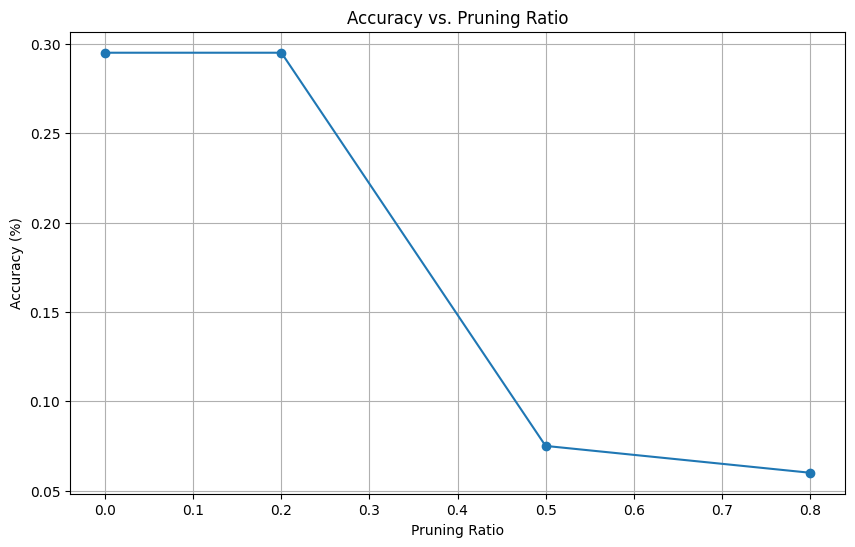


Pruning analysis completed!


In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
import time
import copy
from PIL import Image
import requests
import zipfile
from io import BytesIO
import matplotlib.pyplot as plt
from timm.models import create_model

# 1. 사전학습된 Swin Transformer 모델 로드
def load_pretrained_swin_model(model_name='swin_tiny_patch4_window7_224', pretrained=True):
    """
    사전학습된 Swin Transformer 모델을 불러오는 함수
    """
    print(f"Loading pretrained {model_name}...")
    model = create_model(
        model_name,
        pretrained=pretrained,
        num_classes=1000
    )
    return model

# 2. 모델 프루닝 구현 (Lottery Ticket Hypothesis 기반)
class PruningManager:
    def __init__(self, model, prune_ratio=0.2):
        """
        모델 프루닝을 관리하는 클래스

        Args:
            model: 프루닝할 모델
            prune_ratio: 프루닝할 파라미터의 비율 (0.0~1.0)
        """
        self.model = model
        self.prune_ratio = prune_ratio
        self.masks = {}
        self.original_params = {}
        self.pruned_model = None

    def generate_masks(self):
        """
        Lottery Ticket Hypothesis에 따른 마스크 생성
        """
        print("Generating pruning masks...")

        # 모든 파라미터에 대한 마스크 생성
        for name, param in self.model.named_parameters():
            if 'weight' in name and param.dim() > 1:  # 가중치 행렬에 대해서만 프루닝 적용
                self.original_params[name] = param.data.clone()

                # 절대값 기준으로 하위 prune_ratio에 해당하는 파라미터 마스킹
                tensor = param.data.cpu().numpy()
                abs_tensor = np.abs(tensor)
                cutoff_rank = round(tensor.size * self.prune_ratio)
                cutoff_value = np.sort(abs_tensor.flatten())[cutoff_rank]

                # 마스크 생성 (값이 작은 파라미터는 0, 그렇지 않은 파라미터는 1)
                mask = torch.ones_like(param.data)
                mask[abs(param.data) <= cutoff_value] = 0
                self.masks[name] = mask

                # 마스크 적용된 파라미터의 비율 출력
                zero_count = torch.sum(mask == 0).item()
                total_count = mask.numel()
                print(f"{name}: {zero_count}/{total_count} parameters pruned ({zero_count/total_count:.2%})")

    def apply_masks(self):
        """
        생성된 마스크를 모델에 적용
        """
        print("Applying masks to model parameters...")
        for name, param in self.model.named_parameters():
            if name in self.masks:
                param.data *= self.masks[name]

    def get_pruned_model(self):
        """
        프루닝된 모델 반환
        """
        self.pruned_model = copy.deepcopy(self.model)

        # 프루닝된 모델에 마스크 적용
        for name, param in self.pruned_model.named_parameters():
            if name in self.masks:
                param.data *= self.masks[name]

        return self.pruned_model

    def prune(self):
        """
        프루닝 과정 실행
        """
        self.generate_masks()
        return self.get_pruned_model()

# 3. Tiny ImageNet 데이터셋 다운로드 및 처리
class TinyImageNet:
    def __init__(self, root='tiny-imagenet-200', download=True):
        """
        Tiny ImageNet 데이터셋 관리 클래스
        """
        self.root = root
        self.data_dir = os.path.join(os.getcwd(), root)

        if download and not os.path.exists(self.data_dir):
            self._download()

        # 데이터셋 경로 설정
        self.train_dir = os.path.join(self.data_dir, 'train')
        self.val_dir = os.path.join(self.data_dir, 'val')

        # 검증 데이터셋 구조 정리
        self._organize_val_data()

        # 데이터셋 로드
        self.train_dataset, self.val_dataset = self._load_datasets()

    def _download(self):
        """
        Tiny ImageNet 데이터셋 다운로드
        """
        print("Downloading Tiny ImageNet dataset...")
        url = 'http://cs231n.stanford.edu/tiny-imagenet-200.zip'
        response = requests.get(url)

        # 데이터셋 압축 해제
        print("Extracting dataset...")
        z = zipfile.ZipFile(BytesIO(response.content))
        z.extractall(os.getcwd())
        print(f"Dataset extracted to {self.data_dir}")

    def _organize_val_data(self):
        """
        검증 데이터셋의 구조 정리 (클래스별 폴더로 재구성)
        """
        # 이미 구성되어 있으면 건너뜀
        if os.path.exists(os.path.join(self.val_dir, 'n01443537')):
            return

        # val_annotations.txt 파일에서 이미지-클래스 매핑 정보 읽기
        val_anno_path = os.path.join(self.val_dir, 'val_annotations.txt')
        val_img_dir = os.path.join(self.val_dir, 'images')

        if os.path.exists(val_anno_path) and os.path.exists(val_img_dir):
            print("Organizing validation data...")

            # 이미지-클래스 매핑 정보 읽기
            with open(val_anno_path, 'r') as f:
                val_anno = f.readlines()

            # 각 클래스별 폴더 생성
            for line in val_anno:
                parts = line.strip().split('\t')
                img_name, class_id = parts[0], parts[1]

                # 클래스 폴더 생성
                class_dir = os.path.join(self.val_dir, class_id)
                if not os.path.exists(class_dir):
                    os.makedirs(class_dir)

                # 이미지 이동
                img_path = os.path.join(val_img_dir, img_name)
                if os.path.exists(img_path):
                    img = Image.open(img_path)
                    img.save(os.path.join(class_dir, img_name))

    def _load_datasets(self):
        """
        Tiny ImageNet 데이터셋 로드
        """
        # 데이터 변환 정의
        transform = transforms.Compose([
            transforms.Resize(224),  # Swin Transformer 입력 크기에 맞춤
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        # 학습 및 검증 데이터셋 로드
        train_dataset = datasets.ImageFolder(self.train_dir, transform=transform)
        val_dataset = datasets.ImageFolder(self.val_dir, transform=transform)

        print(f"Loaded {len(train_dataset)} training images and {len(val_dataset)} validation images")
        return train_dataset, val_dataset

    def get_loaders(self, batch_size=64, num_workers=4):
        """
        데이터 로더 반환
        """
        train_loader = DataLoader(
            self.train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers
        )

        val_loader = DataLoader(
            self.val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers
        )

        return train_loader, val_loader

# 4. 모델 평가
def evaluate_model(model, data_loader, device):
    """
    모델 평가 함수
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    accuracy = 100.0 * correct / total
    return accuracy

# 메인 실행 함수
def main():
    # 디바이스 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # 사전학습된 Swin Transformer 모델 로드
    model = load_pretrained_swin_model()
    model = model.to(device)

    # Tiny ImageNet 데이터셋 로드
    tiny_imagenet = TinyImageNet(download=True)
    train_loader, val_loader = tiny_imagenet.get_loaders(batch_size=32)

    # 원본 모델 평가
    print("\nEvaluating original model...")
    original_accuracy = evaluate_model(model, val_loader, device)
    print(f"Original model accuracy: {original_accuracy:.2f}%")

    # 다양한 프루닝 비율 테스트
    prune_ratios = [0.2, 0.5, 0.8]
    pruned_accuracies = []

    for ratio in prune_ratios:
        print(f"\nPruning with ratio {ratio:.2f}...")
        pruning_manager = PruningManager(model, prune_ratio=ratio)
        pruned_model = pruning_manager.prune()
        pruned_model = pruned_model.to(device)

        # 프루닝된 모델 평가
        pruned_accuracy = evaluate_model(pruned_model, val_loader, device)
        print(f"Pruned model accuracy (ratio={ratio:.2f}): {pruned_accuracy:.2f}%")
        pruned_accuracies.append(pruned_accuracy)

    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot([0] + prune_ratios, [original_accuracy] + pruned_accuracies, 'o-')
    plt.xlabel('Pruning Ratio')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs. Pruning Ratio')
    plt.grid(True)
    plt.savefig('pruning_results.png')
    plt.show()

    print("\nPruning analysis completed!")

if __name__ == "__main__":
    main()